<a href="https://colab.research.google.com/github/jal9o3/OLA/blob/dev/OLA_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load the data

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

INPUT_SIZE = 147
OUTPUT_SIZE = 254

class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)
        self.inputs = torch.tensor(self.data.iloc[:, :INPUT_SIZE].values, dtype=torch.float32)
        self.outputs = torch.tensor(self.data.iloc[:, INPUT_SIZE:INPUT_SIZE+OUTPUT_SIZE].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]

# Usage
dataset = CustomDataset('training_data.csv')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


# Define the neural network

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

INPUT_SIZE = 147
OUTPUT_SIZE = 254

class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, OUTPUT_SIZE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)  # Apply softmax along the appropriate dimension
        return x

class FiveLayer(nn.Module):
    def __init__(self):
        super(FiveLayer, self).__init__()
        self.fc1 = nn.Linear(INPUT_SIZE, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, OUTPUT_SIZE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return F.softmax(x, dim=1)

# Initialize the model
model = FiveLayer()

# Train the model

In [ ]:
import torch.optim as optim

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, targets in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 0.0003
Epoch [2/100], Loss: 0.0001
Epoch [3/100], Loss: 0.0001
Epoch [4/100], Loss: 0.0001
Epoch [5/100], Loss: 0.0001
Epoch [6/100], Loss: 0.0001
Epoch [7/100], Loss: 0.0001
Epoch [8/100], Loss: 0.0002
Epoch [9/100], Loss: 0.0001
Epoch [10/100], Loss: 0.0001
Epoch [11/100], Loss: 0.0001
Epoch [12/100], Loss: 0.0001
Epoch [13/100], Loss: 0.0001
Epoch [14/100], Loss: 0.0001
Epoch [15/100], Loss: 0.0001
Epoch [16/100], Loss: 0.0001
Epoch [17/100], Loss: 0.0001
Epoch [18/100], Loss: 0.0001
Epoch [19/100], Loss: 0.0001
Epoch [20/100], Loss: 0.0001
Epoch [21/100], Loss: 0.0001
Epoch [22/100], Loss: 0.0001
Epoch [23/100], Loss: 0.0001
Epoch [24/100], Loss: 0.0001
Epoch [25/100], Loss: 0.0002
Epoch [26/100], Loss: 0.0001
Epoch [27/100], Loss: 0.0001
Epoch [28/100], Loss: 0.0001
Epoch [29/100], Loss: 0.0001
Epoch [30/100], Loss: 0.0001
Epoch [31/100], Loss: 0.0001
Epoch [32/100], Loss: 0.0001
Epoch [33/100], Loss: 0.0001
Epoch [34/100], Loss: 0.0001
Epoch [35/100], Loss: 0

# Save the model

In [ ]:
torch.save(model.state_dict(), 'model.pth')

# Clone the OLA engine repository

In [ ]:
!git clone https://github.com/jal9o3/OLA.git

Cloning into 'OLA'...
remote: Enumerating objects: 872, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 872 (delta 69), reused 80 (delta 43), pack-reused 758 (from 1)
Receiving objects: 100% (872/872), 228.22 KiB | 1.14 MiB/s, done.
Resolving deltas: 100% (530/530), done.


In [ ]:
!cd OLA && git checkout dev

Branch 'dev' set up to track remote branch 'dev' from 'origin'.
Switched to a new branch 'dev'


# Define new match simulator to analyze winrate

In [ ]:
import os
os.chdir('./OLA')

In [ ]:
import random

import matplotlib.pyplot as plt

from core import Board, Infostate, Player
from constants import Controller
from training import (TimelessBoard, CFRTrainingSimulator, DirectionFilter,
                      ActionsFilter)
from simulation import MatchSimulator

class TestingController(Controller):
  """
  This adds the model as a new possible controller.
  """
  MODEL = 3


class ModelTestingSimulator(CFRTrainingSimulator):
  """
  This simulates a match that utilizes a trained OLA model.
  """

  def __init__(self, formations: list[list[int]], controllers: list[int],
                 save_data: bool, pov: int):
        super().__init__(formations, controllers, save_data, pov)
        self.controllers = controllers # Undo the nullification in superclass

  @staticmethod
  def get_model_decision(model, board: Board, infostate: Infostate,
                         actions_filter: ActionsFilter):
    """
    This is for obtaining the model's chosen action.
    """
    input_infostate = list(map(int, str(infostate).split(" ")))
    # Convert input_infostate to a PyTorch Tensor
    input_infostate = torch.tensor(input_infostate, dtype=torch.float32)
    # Reshape the input to have an extra dimension
    input_infostate = input_infostate.unsqueeze(0)  # Add a batch dimension
    full_strategy = model(input_infostate)
    # Get the probabilities for each action from the model output
    full_strategy = full_strategy.squeeze(0).tolist()

    fullgame_actions = TimelessBoard.actions()
    valid_actions = board.actions()
    strategy = [0.0 for _ in range(len(valid_actions))]
    for action in fullgame_actions:
        if action not in valid_actions:
            full_strategy[fullgame_actions.index(action)] = 0.0
    if sum(full_strategy) > 0:
        full_strategy = [x / sum(full_strategy) for x in full_strategy]

    for i, action in enumerate(fullgame_actions):
        if action in valid_actions:
          strategy[valid_actions.index(action)] = full_strategy[i]
    if sum(strategy) <= 0:
        strategy = [1/len(valid_actions) for _ in range(len(valid_actions))]

    filtered_actions = actions_filter.filter()
    filtered_strategy = []
    for a, action in enumerate(valid_actions):
        if action in filtered_actions:
            filtered_strategy.append(strategy[a])
    normalizing_sum = sum(filtered_strategy)
    if normalizing_sum > 0:
        filtered_strategy = [
            p/normalizing_sum for p in filtered_strategy]
    else:
        # Reset options if all evaluated actions seem bad
        filtered_actions, filtered_strategy = valid_actions, strategy
    action = random.choices(
        filtered_actions, weights=filtered_strategy, k=1)[0]

    return action

  def get_controller_input(self, arbiter_board: Board, infostate: Infostate,
                           actions_filter: ActionsFilter):
      """
      This is for obtaining the controller's chosen action, be it human or
      bot.
      """
      action = "" # Initialize needed value
      valid_actions = arbiter_board.actions()
      if self.get_current_controller(arbiter_board) == Controller.RANDOM:
          action = random.choice(valid_actions)
      elif self.get_current_controller(arbiter_board) == Controller.HUMAN:
          while action not in valid_actions:
              action = input("Choose a move: ")
      elif self.get_current_controller(arbiter_board) == TestingController.MODEL:
          model = FiveLayer()
          model.load_state_dict(torch.load('../model.pth'))
          model.eval()
          action = self.get_model_decision(model, arbiter_board, infostate,
                                           actions_filter)

      return action

  def start(self, iterations: int = 1, target: int = None):
    """
    This is the starting method for the match simulation.
    """
    model_wins = 0
    winning_data = [] # Initialize the data to plot
    for iteration in range(iterations):
      self.blue_formation = list(
                Player.get_sensible_random_formation(
                    piece_list=Ranking.SORTED_FORMATION)
            )
      self.red_formation = self._place_in_red_range(list(
          Player.get_sensible_random_formation(
              piece_list=Ranking.SORTED_FORMATION))
      )
      arbiter_board = Board(self.setup_arbiter_matrix(),
                                    player_to_move=Player.BLUE,
                                    blue_anticipating=False, red_anticipating=False)
      blue_infostate, red_infostate = MatchSimulator._starting_infostates(
                  arbiter_board)
      action, result, previous_action, previous_result, attack_location = (
                  "", "", "", "", None)  # Initialize needed values
      turn_number = 1
      branches_encountered = 0
      while not arbiter_board.is_terminal():
          self.manage_pov_switching(arbiter_board)

          MatchSimulator._print_game_status(turn_number, arbiter_board,
                                            infostates=[
                                                blue_infostate,
                                                red_infostate],
                                            pov=self.pov)
          valid_actions = arbiter_board.actions()
          branches_encountered += len(valid_actions)

          action = ""  # Initialize variable for storing chosen action
          relevant_infostate = (blue_infostate if arbiter_board.player_to_move == Player.BLUE
                                else red_infostate)

          # For the first turns of each player, choose a forward move
          if turn_number in [1, 2]:
              actions_filter = ActionsFilter(state=arbiter_board, directions=DirectionFilter(
                  back=False, right=False, left=False),
                  square_whitelist=[(x, y) for y in range(Board.COLUMNS)
                                    for x in range(Board.ROWS)])
          else:
              actions_filter = CFRTrainingSimulator._get_actions_filter(
                  arbiter_board, previous_action, previous_result, attack_location)

          action = self.get_controller_input(arbiter_board, relevant_infostate,
                                            actions_filter)
          print(f"Chosen Move: {action}")
          previous_action = action  # Store for the next iteration

          new_arbiter_board = arbiter_board.transition(action)
          arbiter_board, result, attack_location = self._process_action(
                      arbiter_board, action)
          previous_result = result  # Store for the next iteration
          blue_infostate, red_infostate = MatchSimulator._update_infostates(
              blue_infostate, red_infostate, action=action, result=result
          )
          arbiter_board = new_arbiter_board
          turn_number += 1

          print(f"Model Wins: {model_wins}")
          print(f"Iteration: {iteration + 1}/{iterations}")

      MatchSimulator._print_result(arbiter_board)
      match_result = MatchSimulator._get_match_result(arbiter_board)
      if match_result == self.player_two_color: # Model controller is Player 2
        model_wins += 1
      model_color = "BLUE" if self.player_two_color == Player.BLUE else "RED"
      print(f"Model: {model_color}")

      winning_data.append([model_wins, iteration + 1])

    print(f"Model Winrate: {(model_wins/iterations)*100: .2f}")

    # Calculate the percentage ratios
    percentages = [(a / b) * 100 for a, b in winning_data]

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(percentages, marker='o', linestyle='-', color='b')
    plt.title('Win Rate over Measurement Iterations')
    plt.xlabel('Iteration #')
    plt.ylabel('Measured Win Rate (%)')
    plt.grid(True)
    plt.show()

Turn Number: 1

 0  b2  -  - b2 bE  - b8  - b2 
 1  b2 bD  -  - bC bF b1 b5 b4 
 2  b9 bB bF bA b7 b2 b6 b2 b3 
 3   -  -  -  -  -  -  -  -  - 
 4   -  -  -  -  -  -  -  -  - 
 5  r2  - r6  - r3 rA r2  - rD 
 6  rE rF r2  - rB r5 r8 r2 rF 
 7  r1  - r2  - r9 rC r7 r4 r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 1
Chosen Move: 1413
Model Wins: 0
Iteration: 1/200
Turn Number: 2

 0  b2  -  - b2 bE  - b8  - b2 
 1  b2 bD  - bC  - bF b1 b5 b4 
 2  b9 bB bF bA b7 b2 b6 b2 b3 
 3   -  -  -  -  -  -  -  -  - 
 4   -  -  -  -  -  -  -  -  - 
 5  r2  - r6  - r3 rA r2  - rD 
 6  rE rF r2  - rB r5 r8 r2 rF 
 7  r1  - r2  - r9 rC r7 r4 r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 2
Chosen Move: 5444
Model Wins: 0
Iteration: 1/200
Turn Number: 3

 0  b2  -  - b2 bE  - b8  - b2 
 1  b2 bD  - bC  - bF b1 b5 b4 
 2  b9 bB bF bA b7 b2 b6 b2 b3 
 3   -  -  -  -  -  -  -  -  - 
 4   -  -  -  - r3  -  -  -  - 
 5  r2  - r6  -  - rA r2  - rD 
 6  rE rF r2  - rB r5 r8 r2 rF 
 7  r1  - r2  - 

<ipython-input-9-4f455fd5ff58>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('../model.pth'))


Streaming output truncated to the last 5000 lines.
 3  rD  - r7  - r2  -  - bC b9 
 4   -  -  -  -  -  -  -  -  - 
 5   -  - bF  -  - r2  -  -  - 
 6   - r2  -  -  -  -  -  - rA 
 7  r1 rF rF r8  - rC rB r9 r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 1
Chosen Move: 2120
Model Wins: 128
Iteration: 198/200
Turn Number: 116

 0  b2 b2 b4 bD bF b1 b5  - b7 
 1   - bA b2 bB  -  -  -  -  - 
 2  b2  - b3  -  - bE  -  -  - 
 3  rD  - r7  - r2  -  - bC b9 
 4   -  -  -  -  -  -  -  -  - 
 5   -  - bF  -  - r2  -  -  - 
 6   - r2  -  -  -  -  -  - rA 
 7  r1 rF rF r8  - rC rB r9 r2 

     0  1  2  3  4  5  6  7  8 
Player to move: 2
Chosen Move: 3231
Model Wins: 128
Iteration: 198/200
Turn Number: 117

 0  b2 b2 b4 bD bF b1 b5  - b7 
 1   - bA b2 bB  -  -  -  -  - 
 2  b2  - b3  -  - bE  -  -  - 
 3  rD r7  -  - r2  -  - bC b9 
 4   -  -  -  -  -  -  -  -  - 
 5   -  - bF  -  - r2  -  -  - 
 6   - r2  -  -  -  -  -  - rA 
 7  r1 rF rF r8  - rC rB r9 r2 

     0  1  2  3  4  5  6  7  8 


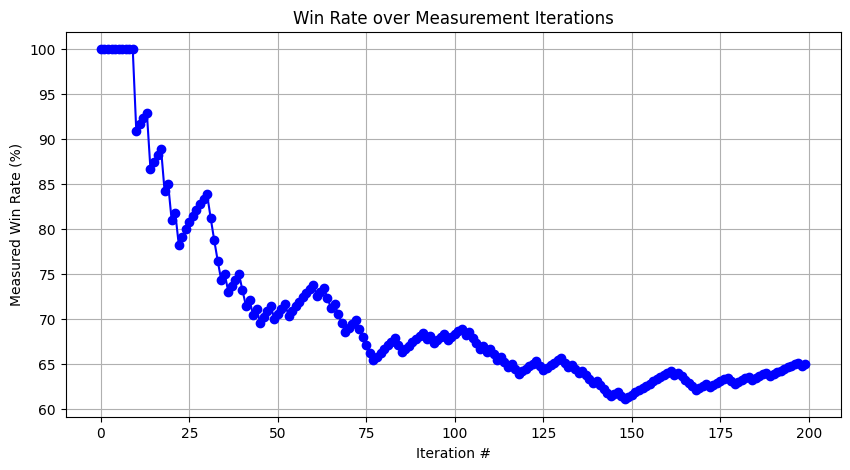

In [11]:
from constants import Ranking, Controller, POV

# Sample random formations
blue_formation = list(
    Player.get_sensible_random_formation(
        piece_list=Ranking.SORTED_FORMATION)
)
red_formation = list(
    Player.get_sensible_random_formation(
        piece_list=Ranking.SORTED_FORMATION)
)

match_simulator = ModelTestingSimulator(formations=[blue_formation, red_formation],
                                  controllers=[
                                      Controller.RANDOM, TestingController.MODEL],
                                  save_data=False,
                                  pov=POV.WORLD)
match_simulator.start(iterations=200)